# Tutorial on using the Platform

This guide will show you how to use the platform and provide a detailed breakdown of how it works.

## Initialization

First we need to import the necessary class

In [1]:
import sys, glob, os
from commons import convert_to_json, triq_optimization, qiskit_optimization, \
    calibration_type_enum, qiskit_compilation_enum, normalize_counts, calculate_success_rate_tvd, \
    convert_dict_binary_to_int, convert_dict_int_to_binary, sum_last_n_digits_dict
import wrappers.qiskit_wrapper as qiskit_wrapper
from wrappers.qiskit_wrapper import QiskitCircuit
import pandas as pd
import mthree
import mapomatic as mm
import mthree

from qiskit.quantum_info import SparsePauliOp
from qiskit import QuantumCircuit
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime.options import SamplerOptions, EstimatorOptions, DynamicalDecouplingOptions, TwirlingOptions

from qiskit_aer import AerSimulator, QasmSimulator, Aer
from qiskit.qasm2 import dumps
import matplotlib.pyplot as plt
import numpy as np

#import mitiq
#from mitiq import zne, benchmarks

from qEmQUIP import QEM, conf

CB_color_cycle = ['#1F77B4', '#AEC7E8', '#FF7F0E', '#FFBB78', '#2CA02C', '#98DF8A', '#D62728', '#FF9896',
                  '#9467BD', '#C5B0D5', '#8C564B', '#C49C94', '#E377C2', '#F7B6D2', '#7F7F7F', '#C7C7C7',
                  '#BCBD22', '#DBDB8D', '#17BECF', '#9EDAE5'
                  ]

markers = ['o', 'v', '^', 's', '+', '*', 'x', 'd', '<', '>', 'p']
linestyles = ['-', '--', '-.', ':', '-', '--', '-.', ':']



Here we need to initialize the object, please check the `config.ini` file to update the general config

In [2]:
# Put your Qiskit Token
token = "74076e69ed0d571c8e0ff8c0b2c912c28681d47426cf16a5d817825de16f7dbd95bf6ff7c604b706803b78b2e21d1dd5cacf9f1b0aa81d672d938bded8049a17"
q = QEM(runs=conf.runs, user_id=conf.user_id, token=token, skip_db=True)

Time for setup the services: 5.585620325000491 seconds


### Update the configs from the collected calibration data

To update the fake backend calibration data

In [3]:
# q.update_hardware_configs()

In [4]:
# qiskit_wrapper.generate_new_props(q.backend, "avg")
# qiskit_wrapper.generate_new_props(q.backend, "mix")
# qiskit_wrapper.generate_new_props(q.backend, "recent_15_adjust")

# Detailed breakdown

### Set the backend

There are two program types for the backend: `Sampler` or `Estimator`. Here it is also possible to add the options for DynamicalDecoupling (DD) and Twirling, which will be explained later.

In [5]:
q.set_backend(program_type="sampler")

Time for setup the backends: 0.00010958899838442449 seconds


## Prepare the circuits

You can get the quantum circuit from a folder contains the qasm files or qasm string

In [6]:
# The path is coming from the config file, but you can also modify it here
conf.base_folder = "./circuits/testing/"
qasm_files = q.get_qasm_files_from_path()
print(qasm_files)

['./circuits/testing/adder_n7.qasm']


Get the circuits from file

In [7]:
qc = q.get_circuit_properties(qasm_source=qasm_files[0])
qc.circuit.draw(idle_wires=False)

┌───────────┐                                               »
q_0: ─┤ U3(π,0,π) ├───────────────────────────────────────────────»
      ├───────────┤                                               »
q_1: ─┤ U3(π,0,π) ├────────────────────────■──────────────────────»
      └───────────┘                        │                      »
q_2: ─────────────────■────────────────────┼───────────────────■──»
     ┌─────────────┐┌─┴─┐┌──────────────┐┌─┴─┐┌─────────────┐┌─┴─┐»
q_3: ┤ U3(π/2,0,π) ├┤ X ├┤ U3(0,0,-π/4) ├┤ X ├┤ U3(0,0,π/4) ├┤ X ├»
     └┬───────────┬┘└───┘└──────────────┘└───┘└─────────────┘└───┘»
q_4: ─┤ U3(π,0,π) ├────────────────────────■──────────────────────»
      ├───────────┤                        │                      »
q_5: ─┤ U3(π,0,π) ├───■────────────────────┼───────────────────■──»
     ┌┴───────────┴┐┌─┴─┐┌──────────────┐┌─┴─┐┌─────────────┐┌─┴─┐»
q_6: ┤ U3(π/2,0,π) ├┤ X ├┤ U3(0,0,-π/4) ├┤ X ├┤ U3(0,0,π/4) ├┤ X ├»
     └─────────────┘└───┘└──────────────┘└───┘└─────────────┘└───┘»
c: 7/═════════════════════════════════════════════════════════════»
                                                                  »
«                                                                             »
«q_0: ────────────────────────────────────────────────────────────────────────»
«                                         ┌─────────────┐                     »
«q_1: ──────────────────■─────────■───────┤ U3(0,0,π/4) ├────────■─────────■──»
«     ┌─────────────┐   │       ┌─┴─┐     ├─────────────┴┐     ┌─┴─┐     ┌─┴─┐»
«q_2: ┤ U3(0,0,π/4) ├───┼───────┤ X ├─────┤ U3(0,0,-π/4) ├─────┤ X ├─────┤ X ├»
«     ├─────────────┴┐┌─┴─┐┌────┴───┴────┐├─────────────┬┘┌────┴───┴────┐└───┘»
«q_3: ┤ U3(0,0,-π/4) ├┤ X ├┤ U3(0,0,π/4) ├┤ U3(π/2,0,π) ├─┤ U3(π/2,0,π) ├─────»
«     └──────────────┘└───┘└─────────────┘├─────────────┤ └─────────────┘     »
«q_4: ──────────────────■─────────■───────┤ U3(0,0,π/4) ├────────■─────────■──»
«     ┌─────────────┐   │       ┌─┴─┐     ├─────────────┴┐     ┌─┴─┐     ┌─┴─┐»
«q_5: ┤ U3(0,0,π/4) ├───┼───────┤ X ├─────┤ U3(0,0,-π/4) ├─────┤ X ├─────┤ X ├»
«     ├─────────────┴┐┌─┴─┐┌────┴───┴────┐├─────────────┬┘┌────┴───┴────┐└───┘»
«q_6: ┤ U3(0,0,-π/4) ├┤ X ├┤ U3(0,0,π/4) ├┤ U3(π/2,0,π) ├─┤ U3(π/2,0,π) ├─────»
«     └──────────────┘└───┘└─────────────┘└─────────────┘ └─────────────┘     »
«c: 7/════════════════════════════════════════════════════════════════════════»
«                                                                             »
«                                                                 »
«q_0: ───────────────────────────────■────────────────────────────»
«          ┌─┐                       │                            »
«q_1: ─────┤M├───────────────────────┼────────────────────────────»
«          └╥┘                       │                            »
«q_2: ──■───╫────────────────────────┼─────────────────────────■──»
«     ┌─┴─┐ ║ ┌──────────────┐     ┌─┴─┐      ┌─────────────┐┌─┴─┐»
«q_3: ┤ X ├─╫─┤ U3(0,0,-π/4) ├─────┤ X ├──────┤ U3(0,0,π/4) ├┤ X ├»
«     └───┘ ║ └─────┬─┬──────┘     └───┘      └─────────────┘└───┘»
«q_4: ──────╫───────┤M├───────────────────────────────────────────»
«           ║       └╥┘                                           »
«q_5: ──■───╫────────╫────────────────────────────────────────────»
«     ┌─┴─┐ ║        ║        ┌──────────────┐                    »
«q_6: ┤ X ├─╫────────╫────────┤ U3(0,0,-π/4) ├────────────────────»
«     └───┘ ║        ║        └──────────────┘                    »
«c: 7/══════╩════════╩════════════════════════════════════════════»
«           1        4                                            »
«                                         ┌─────────────┐                     »
«q_0: ──────────────────■─────────■───────┤ U3(0,0,π/4) ├───■─────────■───────»
«                       │         │       └─────────────┘   │         │       »
«q_1: ──────────────────┼─────────┼─────────────────────────┼─────────┼───────»
«     ┌───────

Or you can also get it from the qasm strings

In [8]:
qasm_text = """OPENQASM 2.0;
include "qelib1.inc";
qreg q[2];
creg c[2];
h q[0];
cx q[0], q[1];
barrier q[0], q[1];
measure q[0] -> c[0];
measure q[1] -> c[1];
"""

qc = q.get_circuit_properties(qasm_source=qasm_text)
qc.circuit.draw(idle_wires=False)

┌─────────────┐      ░ ┌─┐   
q_0: ┤ U3(π/2,0,π) ├──■───░─┤M├───
     └─────────────┘┌─┴─┐ ░ └╥┘┌─┐
q_1: ───────────────┤ X ├─░──╫─┤M├
                    └───┘ ░  ║ └╥┘
c: 2/════════════════════════╩══╩═
                             0  1

`q.get_circuit_properties` will give an object of `QiskitCircuit` which will give the information of the circuits: 
- `circuit`: `QuantumCircuit` object from Qiskit
- `depth`: circuit depth
- `gates`: number of gates used in the circuit
- `total_gates`: number of total gates used in the circuit
- `correct_output`: noiseless output from the simulation
- `qasm`: OpenQASM2 file from the circuit translated to `U3` and `cx` gates
- `qasm_original`: OpenQASM2 file from the circuit original


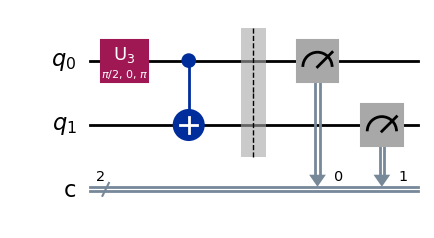

In [9]:
qc.circuit.draw("mpl")

In [10]:
print("Number of depth:", qc.depth)
print("Number of gates:", qc.gates)
print("Number of total gates:", qc.total_gate) 
print("Noiseless simulation output:", qc.correct_output)
print("Circuit Qasm:", qc.qasm)

Number of depth: 3
Number of gates: {'measure': 2, 'u3': 1, 'cx': 1, 'barrier': 1}
Number of total gates: 5
Noiseless simulation output: {'3': 0.4966, '0': 0.5034}
Circuit Qasm: OPENQASM 2.0;
include "qelib1.inc";
qreg q[2];
creg c[2];
u3(pi/2,0,pi) q[0];
cx q[0],q[1];
barrier q[0],q[1];
measure q[0] -> c[0];
measure q[1] -> c[1];


## Compilation Techniques

### Qiskit

We integrated several compilation techniques from Qiskit.

Note: After Qiskit 1.0, Noise-Adaptive (NA) initial layout method has been removed.

In [11]:
print("Existing Qiskit Compilation Options:")
for member in qiskit_compilation_enum:
    if not "NA" in member.name:
        print(member.name)

Existing Qiskit Compilation Options:
qiskit_0
qiskit_3
mapomatic_lcd
mapomatic_avg
mapomatic_mix
mapomatic_avg_adj
mapomatic_w15_adj


In [12]:
for member in qiskit_compilation_enum:
    if not "NA" in member.name:
        updated_qasm, initial_mapping = q.compile(qasm=qc.qasm_original, compilation_name=member.name)
        print(member.name, initial_mapping)

qiskit_0 [20, 19]
qiskit_3 [23, 24]
mapomatic_lcd [16, 26]
mapomatic_avg [1, 0]
mapomatic_mix [0, 1]
mapomatic_avg_adj [1, 0]
mapomatic_w15_adj [1, 0]


In [13]:
print(updated_qasm)

OPENQASM 2.0;
include "qelib1.inc";
qreg q[127];
creg c[2];
rz(pi/2) q[0];
sx q[0];
rz(pi/2) q[0];
cx q[0],q[1];
barrier q[0],q[1];
measure q[0] -> c[0];
measure q[1] -> c[1];


### TriQ

Also, we integrate TriQ Compilation with different options.

Qubit placement options:
- `na`: initial mapping from Noise-adaptive technique []
- `mapo`: initial mapping from Mapomatic technique []
- `sabre`: initial mapping from SABRE []

Calibration type options:
- `lcd` : TriQ's routing with last calibration data.
- `avg` : TriQ's routing with average calibration data.
- `mix` : TriQ's routing with mix calibration data. (Mix = if the qubits calibrated today, we will use the last calibration data for that qubit, otherwise we will use the average)
- `w15` : TriQ's routing with average calibration data of 15 days from the qubit is compiled.

The combinations of name become: `triq_<calibration_type>_<layout>`. For examples:
- `triq_avg_na`
- `triq_mix_sabre`

**Note: From Qiskit version > 1.0.0, `noise_adaptive` layout has been removed**

In [14]:
updated_qasm, initial_mapping = q.compile(qasm=qc.qasm_original, compilation_name="triq_avg_sabre")
print(updated_qasm)

print(initial_mapping)

OPENQASM 2.0;
include "qelib1.inc";
qreg q[127];
creg c[127];
u2(0,3.14159265358979) q[106];
cx q[106],q[105];
measure q[106] -> c[0];
measure q[105] -> c[1];

[106, 105]


## Initiate Noisy simulator

To play around with the noise, we can get retrieve the last recorded calibration data from IBM's backend, and scale down the error


In [15]:
noise_model, noisy_simulator, coupling_map = qiskit_wrapper.get_noisy_simulator(q.backend, 1)

## Running the compiled circuit to the simulator

First, we need to transpile the circuit to the targeted backend

In [16]:
qc = QiskitCircuit(updated_qasm)
circuit = qc.transpile_to_target_backend(q.backend)
#circuit.draw("mpl", idle_wires=False, fold=60)

In [17]:
shots = 5000
q.set_backend(program_type="sampler", backend=noisy_simulator, shots=shots)

Time for setup the backends: 0.0001321440013271058 seconds


In [18]:
job = q.program.run(pubs=[circuit])
result = job.result()[0]
output = result.data.c.get_counts()
output_normalize = normalize_counts(output, shots=shots)
shortened_output = sum_last_n_digits_dict(output, len(initial_mapping))
#shortened_output

## Calculate the Fidelity

We use Total Variation Distance (TVD) to calculate the fidelity of the result

In [19]:
fidelity = calculate_success_rate_tvd(qc.correct_output,output_normalize)
fidelity

0.9836

## Error Mitigation (mthree)

Matrix-free Measurement Mitigation (M3).

M3 is a measurement mitigation technique that solves for corrected measurement probabilities using a dimensionality reduction step followed by either direct LU factorization or a preconditioned iterative method that nominally converges in O(1) steps, and can be computed in parallel. For example, M3 can compute corrections on 42 qubit GHZ problems in under two seconds on a quad-core machine (depending on the number of unique bitstrings in the output).

You can find more information about M3 [here](https://qiskit-extensions.github.io/mthree/)

In [20]:
from qiskit_ibm_runtime import QiskitRuntimeService
qiskit_token = token

QiskitRuntimeService.save_account(channel="ibm_quantum", token=qiskit_token, overwrite=True)
service = QiskitRuntimeService(channel="ibm_quantum", token=qiskit_token)
backend_service = service.backend("ibm_sherbrooke")
backend_sim = AerSimulator.from_backend(backend_service)

In [21]:
#probs_m3 = q.apply_mthree(noisy_simulator, initial_mapping, output, shots)
probs_m3 = q.apply_mthree(backend_sim, initial_mapping, output, shots)
fidelity_m3 = calculate_success_rate_tvd(qc.correct_output, probs_m3)
overhead = (fidelity_m3 - fidelity) / fidelity_m3
print(fidelity, fidelity_m3, overhead)

0.9836 0.9946940363468514 0.011153214899725051


## Dynamical Decoupling

qubits can lose their information over time due to decoherence and can further be influenced by operations applied to other qubits via cross talk. These effects are especially recognizable if the qubits are already initialized in a quantum state but are not being used for an extended period during the calculation.

To eliminate these effects, we can use dynamic decoupling, which adds pulse sequences (known as dynamical decoupling sequences) to flip idle qubits around the Bloch sphere, canceling the effect of noise channels and thereby suppressing the decoherence effect.

You can find more information about the dynamical decoupling [here](https://docs.quantum.ibm.com/transpile/dynamical-decoupling-pass-manager).

In [22]:
circuit_dd = q.apply_dd(circuit, noisy_simulator, sequence_type="XX", scheduling_method="asap")
#circuit_dd.draw("mpl", idle_wires=False)

# Put all of them together

In [23]:
res_circuit_name = []
res_compilations = []
res_noise_levels = []
res_success_rate = []
res_success_rate_dd = []
res_success_rate_m3 = []
res_success_rate_dd_m3 = []

# Prepare the object
q = QEM(runs=conf.runs, user_id=conf.user_id, token=token)

# prepare the backend
q.set_backend(program_type="sampler")

# prepare the circuit
conf.base_folder = "./circuits/testing/"
qasm_files = q.get_qasm_files_from_path()

shots = 100

# select compilation techniques
compilations = ["qiskit_0", "qiskit_3", "triq_lcd_sabre"]
# compilations = ["qiskit_0", "qiskit_3"]

# select the noise levels (0 = noiseless, 1 = noise model from real backend)
# noise_levels = [0.0, 0.1, 0.2, 0.4, 0.6, 0.8, 1.0]
noise_levels = [1.0]


for qasm in qasm_files:
    qc = q.get_circuit_properties(qasm_source=qasm)
    circuit_name = qasm.split("/")[-1].split(".")[0]

    for comp in compilations:    
        updated_qasm, initial_mapping = q.compile(qasm=qc.qasm_original, compilation_name=comp)
        compiled_qc = QiskitCircuit(updated_qasm)
        circuit = compiled_qc.transpile_to_target_backend(q.backend)

        print("Circuit : ", circuit_name, ", Compilation : ", comp)
        
        for noise in noise_levels:
            
            noise_model, noisy_simulator, coupling_map = qiskit_wrapper.get_noisy_simulator(q.backend, noise)
            
            job = noisy_simulator.run(circuit, shots=shots)
            result = job.result()  
            output = result.get_counts()
            output_normalize = normalize_counts(output, shots=shots)

            tvd = calculate_success_rate_tvd(qc.correct_output,output_normalize)

            probs_m3 = q.apply_mthree(noisy_simulator, initial_mapping, output, shots)
            tvd_m3 = calculate_success_rate_tvd(qc.correct_output, probs_m3)
            
            circuit_dd = q.apply_dd(circuit, noisy_simulator, sequence_type="XX", scheduling_method="asap")
            job_dd = noisy_simulator.run(circuit_dd, shots=shots)
            result_dd = job_dd.result()  
            output_dd = result.get_counts()
            output_normalize_dd = normalize_counts(output_dd, shots=shots)

            tvd_dd = calculate_success_rate_tvd(qc.correct_output,output_normalize)

            probs_dd_m3 = q.apply_mthree(noisy_simulator, initial_mapping, output_dd, shots)
            tvd_dd_m3 = calculate_success_rate_tvd(qc.correct_output, probs_m3)
            
            
            print("Noise level :", noise, "- sr :", np.round(tvd,4), ", sr m3:", np.round(tvd_m3,4),
                  ", sr dd :", np.round(tvd_dd,4), ", sr dd m3:", np.round(tvd_dd_m3,4))
            res_circuit_name.append(circuit_name)
            res_compilations.append(comp)
            res_noise_levels.append(noise)
            res_success_rate.append(tvd)
            res_success_rate_m3.append(tvd_m3)
            res_success_rate_dd.append(tvd_dd)
            res_success_rate_dd_m3.append(tvd_dd_m3)

        


Time for setup the services: 4.584532341999875 seconds
Time for setup the backends: 8.451299981970806e-05 seconds
Circuit :  adder_n7 , Compilation :  qiskit_0
Noise level : 1.0 - sr : 0.05 , sr m3: 0.0566 , sr dd : 0.05 , sr dd m3: 0.0566
Circuit :  adder_n7 , Compilation :  qiskit_3
Noise level : 1.0 - sr : 0.03 , sr m3: 0.0276 , sr dd : 0.03 , sr dd m3: 0.0276
Circuit :  adder_n7 , Compilation :  triq_lcd_sabre
Noise level : 1.0 - sr : 0.47 , sr m3: 0.4834 , sr dd : 0.47 , sr dd m3: 0.4834


## Plot the results

In [24]:
df = pd.DataFrame({
        'circuit_name': res_circuit_name,
        'compilation': res_compilations,
        'noise_level': res_noise_levels,
        'success_rate': res_success_rate,
    })

df_dd = pd.DataFrame({
        'circuit_name': res_circuit_name,
        'compilation': res_compilations,
        'noise_level': res_noise_levels,
        'success_rate': res_success_rate_dd,
    })

df_m3 = pd.DataFrame({
        'circuit_name': res_circuit_name,
        'compilation': res_compilations,
        'noise_level': res_noise_levels,
        'success_rate': res_success_rate_m3
    })

df_dd_m3 = pd.DataFrame({
        'circuit_name': res_circuit_name,
        'compilation': res_compilations,
        'noise_level': res_noise_levels,
        'success_rate': res_success_rate_dd_m3
    })

### Combined plot

In [25]:
def create_line_chart_combined(data, y, opt_values, metric, ax, type, ylabel, xlabel, yticks = None, 
                      y_bot = None, y_top = None, figsize = (12,8), c_idx = 0, reindex = None, x_index = "header_id", x_labels = [], i=0):
    tmp = ()
    
    for idx, opt in enumerate(opt_values):
        # print(idx, opt)
        idx_marker = idx + (len(opt_values) * i)
        # idx = idx 
        pivot = pd.pivot_table(data[data[y] == opt], 
                               values=[metric], 
                               index=x_index, 
                               columns=y, 
                               aggfunc='mean')    
        if reindex != 0:
            if reindex is None:
                if len(tmp) == 0:
                    tmp = pivot.index
                else:
                    pivot = pivot.reindex(tmp)
            else:
                pivot = pivot.reindex(reindex)

        idx_color = (idx % (len(markers)))
        # print(idx_color, idx, len(markers))

        # print (pivot)
         
        pivot.plot(kind='line', color=CB_color_cycle[idx], marker=markers[idx], linestyle=linestyles[i], figsize=figsize, ax=ax)

        mean= pivot.mean().mean()

    if i == i:
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        
    
        if yticks is not None:
            ax.set_yticks(yticks)
    
        if y_bot is not None and y_top is not None:
            ax.set_ylim(bottom= y_bot, top= y_top)
    
        if x_labels is not None:
            ax.set_xticks(np.arange(len(x_labels)))
            ax.set_xticklabels(x_labels)
            ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    
        ax.grid()


In [26]:
def show_figure_by_opt_combined(dfs, y, y_values, metric, ylabel, xlabel, legend = None, figsize=(10,6), reindex=None, 
                             x_index = "total_2q", x_labels = [], x_lim = [1, 100], 
                            y_lim = [0,1], title=None, legend_position=None, circuit_name = "", hw_name = ""):
    # y_values = noise_levels

    metrics = [metric]
    row = 1
    col = 1

    fig, ax = plt.subplots(nrows=row, ncols=1)

    yticks = None
    
    for i in range(len(dfs)):
        # print(i)
        create_line_chart_combined(dfs[i], y, y_values, metrics[0], ax, "opt", ylabel, xlabel, yticks, figsize=figsize, reindex=reindex,
                          x_index = x_index, x_labels=x_labels, i=i)

    # n=[]        
    # n.append(ax.axhline(np.NaN, color="gray", linestyle='-.'))

    # l1 = ax.legend(n, ["Mean"], loc=[0.82, 0.49])

    if legend is None:
            l2 = plt.legend()
    else:
        if legend_position == None:
            l2 = plt.legend(legends)
        else:
            l2 = plt.legend(legends, loc = legend_position)
    
    # plt.tight_layout()
    # ax.add_artist(l1)
    plt.xlim(x_lim) 
    plt.ylim(y_lim)
    plt.title(title)
    #plt.savefig("./output/{}_{}_{}.png".format(circuit_name, hw_name, x_index), dpi=500, bbox_inches='tight')
    plt.show()
    
    return plt

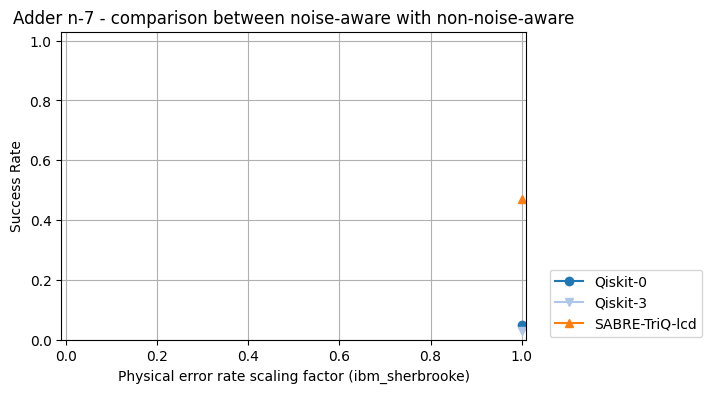

In [27]:
y_values = ['qiskit_0', 'qiskit_3', "triq_lcd_sabre"]
legends  = ["Qiskit-0", "Qiskit-3", "SABRE-TriQ-lcd",
            "Qiskit-0 (M3)", "Qiskit-3 (M3)", "SABRE-TriQ-lcd (M3)"
           ]
x_lim=[-0.01, 1.01]
y_lim=[0,1.03]
legend_position=(0.01,0.01)
circuit_name = "adder"
hw_name = "sherbrooke"
title="Adder n-7 - comparison between noise-aware with non-noise-aware"
x_index = "noise_level"

# print(y_values)
x_labels = None
dfs = [df]

plt = show_figure_by_opt_combined(dfs, "compilation", y_values, "success_rate", "Success Rate", "Physical error rate scaling factor (ibm_sherbrooke)", legends, figsize=(6,4), 
                   reindex=None, x_index = "noise_level", x_labels=x_labels, x_lim=[-0.01, 1.01], y_lim=[0,1.03],legend_position=(1.05,0.01),
                       circuit_name = "adder_n7", hw_name = hw_name, title=title)

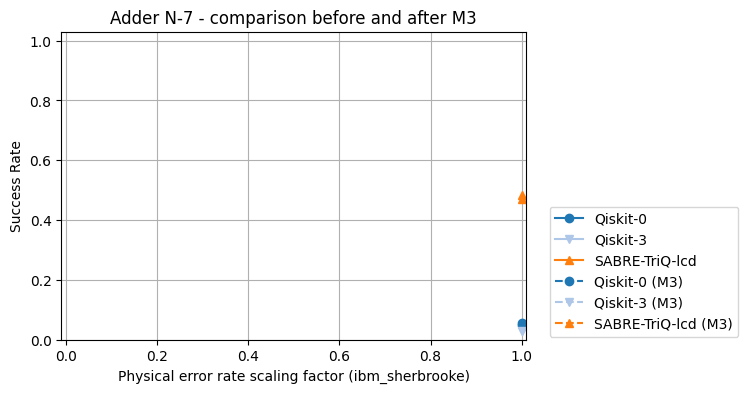

In [28]:
y_values = ['qiskit_0', 'qiskit_3', "triq_lcd_sabre"]
legends  = ["Qiskit-0", "Qiskit-3", "SABRE-TriQ-lcd",
            "Qiskit-0 (M3)", "Qiskit-3 (M3)", "SABRE-TriQ-lcd (M3)"
           ]
x_lim=[-0.01, 1.01]
y_lim=[0,1.03]
legend_position=(0.01,0.01)
circuit_name = "adder"
hw_name = "sherbrooke"
title="Adder N-7 - comparison before and after M3"
x_index = "noise_level"

# print(y_values)
x_labels = None
dfs = [df, df_m3]

plt = show_figure_by_opt_combined(dfs, "compilation", y_values, "success_rate", "Success Rate", "Physical error rate scaling factor (ibm_sherbrooke)", legends, figsize=(6,4), 
                   reindex=None, x_index = "noise_level", x_labels=x_labels, x_lim=[-0.01, 1.01], y_lim=[0,1.03],legend_position=(1.05,0.01),
                       circuit_name = "adder_n7", hw_name = hw_name, title=title)

## Quick Run

### Send to real backend

In [4]:
# prepare the circuit
conf.base_folder = "./circuits/testing/"
qasm_files = q.get_qasm_files_from_path()

# select compilation techniques
compilations = ["qiskit_0", "qiskit_3", "triq_avg_sabre"]
# compilations = ["qiskit_0", "qiskit_3"]

token = "74076e69ed0d571c8e0ff8c0b2c912c28681d47426cf16a5d817825de16f7dbd95bf6ff7c604b706803b78b2e21d1dd5cacf9f1b0aa81d672d938bded8049a17"

In [30]:
q = QEM(runs=conf.runs, user_id=conf.user_id, token=token)
#q.send_to_real_backend("sampler", qasm_files, compilations)

Time for setup the services: 4.11839992899877 seconds


In [5]:
q = QEM(runs=conf.runs, user_id=conf.user_id, token=token)

dd_options: DynamicalDecouplingOptions = {
    'enable':True, 
    'sequence_type':'XpXm',
    'scheduling_method': 'alap'
} 

q.send_to_real_backend("sampler", qasm_files, compilations, dd_options = dd_options)

Time for setup the services: 3.6210741819813848 seconds
Time for running the init header: 0.0006349009927362204 seconds
Compiling circuit: adder_n7 for compilation: qiskit_0
Compiling circuit: adder_n7 for compilation: qiskit_3
Compiling circuit: adder_n7 for compilation: triq_avg_sabre
Total send to real backend : 1
Time for setup the backends: 0.00010582400136627257 seconds
Total no of circuits : 3
Sending to ibm_sherbrooke with batch id: 35 ... 
Sent!
Time for sending to real backend: 2.3901518160128035 seconds


### Send to simulator

#### Sampler

In [5]:
# prepare the circuit
conf.base_folder = "./circuits/testing/"
qasm_files = q.get_qasm_files_from_path()

noise_levels = [0.6, 0.8, 1.0]
shots = 10000
q = QEM(runs=conf.runs, user_id=conf.user_id, token=token)
df = q.run_simulator("sampler", qasm_files, compilations, noise_levels, shots, send_to_db=True)
df

Time for setup the services: 4.476102405000347 seconds
Time for running the init header: 0.00042946899884555023 seconds
Time for setup the backends: 0.0001546219991723774 seconds
Time for setup the backends: 0.001356046999717364 seconds
Time for setup the backends: 0.00226314000065031 seconds
Time for setup the backends: 0.002120043000104488 seconds
Time for setup the backends: 0.002374048999627121 seconds
Time for setup the backends: 0.0024739780001254985 seconds
Time for setup the backends: 0.00276249399939843 seconds
Time for setup the backends: 0.002956415000880952 seconds
Time for setup the backends: 0.0027611810000962578 seconds
Total send to local simulator : 1
Running to Local Simulator with batch id: 38 ... 
Sent!
Time for sending to local simulator: 0.0017574699995748233 seconds


,circuit_name,compilation,noise_level,success_rate
0,adder_n7,qiskit_0,0.6,0.0685
1,adder_n7,qiskit_0,0.8,0.3638
2,adder_n7,qiskit_0,1.0,0.4866
3,adder_n7,qiskit_3,0.6,0.7555
4,adder_n7,qiskit_3,0.8,0.5599
5,adder_n7,qiskit_3,1.0,0.0755
6,adder_n7,triq_avg_sabre,0.6,0.7341
7,adder_n7,triq_avg_sabre,0.8,0.7417
8,adder_n7,triq_avg_sabre,1.0,0.7055


## Get the result

In [6]:
q.get_qiskit_result()

Pending jobs:  1
Checking results for:  simulator with header id : 38
Executed jobs : 1
Getting qasm for : 38 simulator


#### Estimator

**Under progress, still not working!!**

circuits = []
observables = []

circuits.append("""OPENQASM 2.0;
include "qelib1.inc";
qreg q[3];
h q[0];
cx q[0],q[1];
cx q[1],q[2];""")

observables.append(['ZZZ','ZII','IXI','IZI','XII','XXX'])

noise_levels = [0.6, 0.8, 1.0]
q = QEM(runs=conf.runs, user_id=conf.user_id, token=token)
df = q.run_simulator("estimator", circuits, compilations, noise_levels, shots, observables=observables, send_to_db=False)
df


# Mitiq (Pending)

In [22]:
import mitiq
from mitiq import benchmarks
frontend = "qiskit"
print(mitiq.SUPPORTED_PROGRAM_TYPES.keys())
print(mitiq.qem_methods())
shots = 10000

from mitiq.benchmarks import generate_rb_circuits
from mitiq.zne import execute_with_zne
from mitiq.zne.scaling import (
    fold_gates_at_random,
    fold_global,
    fold_all
)
from mitiq.zne.inference import LinearFactory, RichardsonFactory
from mitiq import (
    Calibrator,
    Settings,
    execute_with_mitigation,
    MeasurementResult,
)

from qiskit_ibm_runtime.fake_provider import FakeJakartaV2  # Fake (simulated) QPU

from qiskit import QuantumCircuit
from qiskit import QuantumCircuit, transpile
from qiskit.circuit.library import ECRGate
from qiskit.circuit.library import RZXGate
from mitiq import zne
from mitiq.interface import convert_to_mitiq

['braket', 'cirq', 'pennylane', 'pyquil', 'qibo', 'qiskit']
{'mitiq.cdr': 'Clifford Data Regression', 'mitiq.ddd': 'Digital Dynamical Decoupling', 'mitiq.pec': 'Probabilistic Error Cancellation', 'mitiq.pt': 'Pauli Twirling', 'mitiq.qse': 'Quantum Subspace Expansion', 'mitiq.rem': 'Readout Error Mitigation (confusion inversion)', 'mitiq.zne': 'Zero Noise Extrapolation'}


### ZNE

In [165]:
noise_model, noisy_simulator, coupling_map = qiskit_wrapper.get_noisy_simulator(q.backend, 1)

['./circuits/testing/adder_n10.qasm']


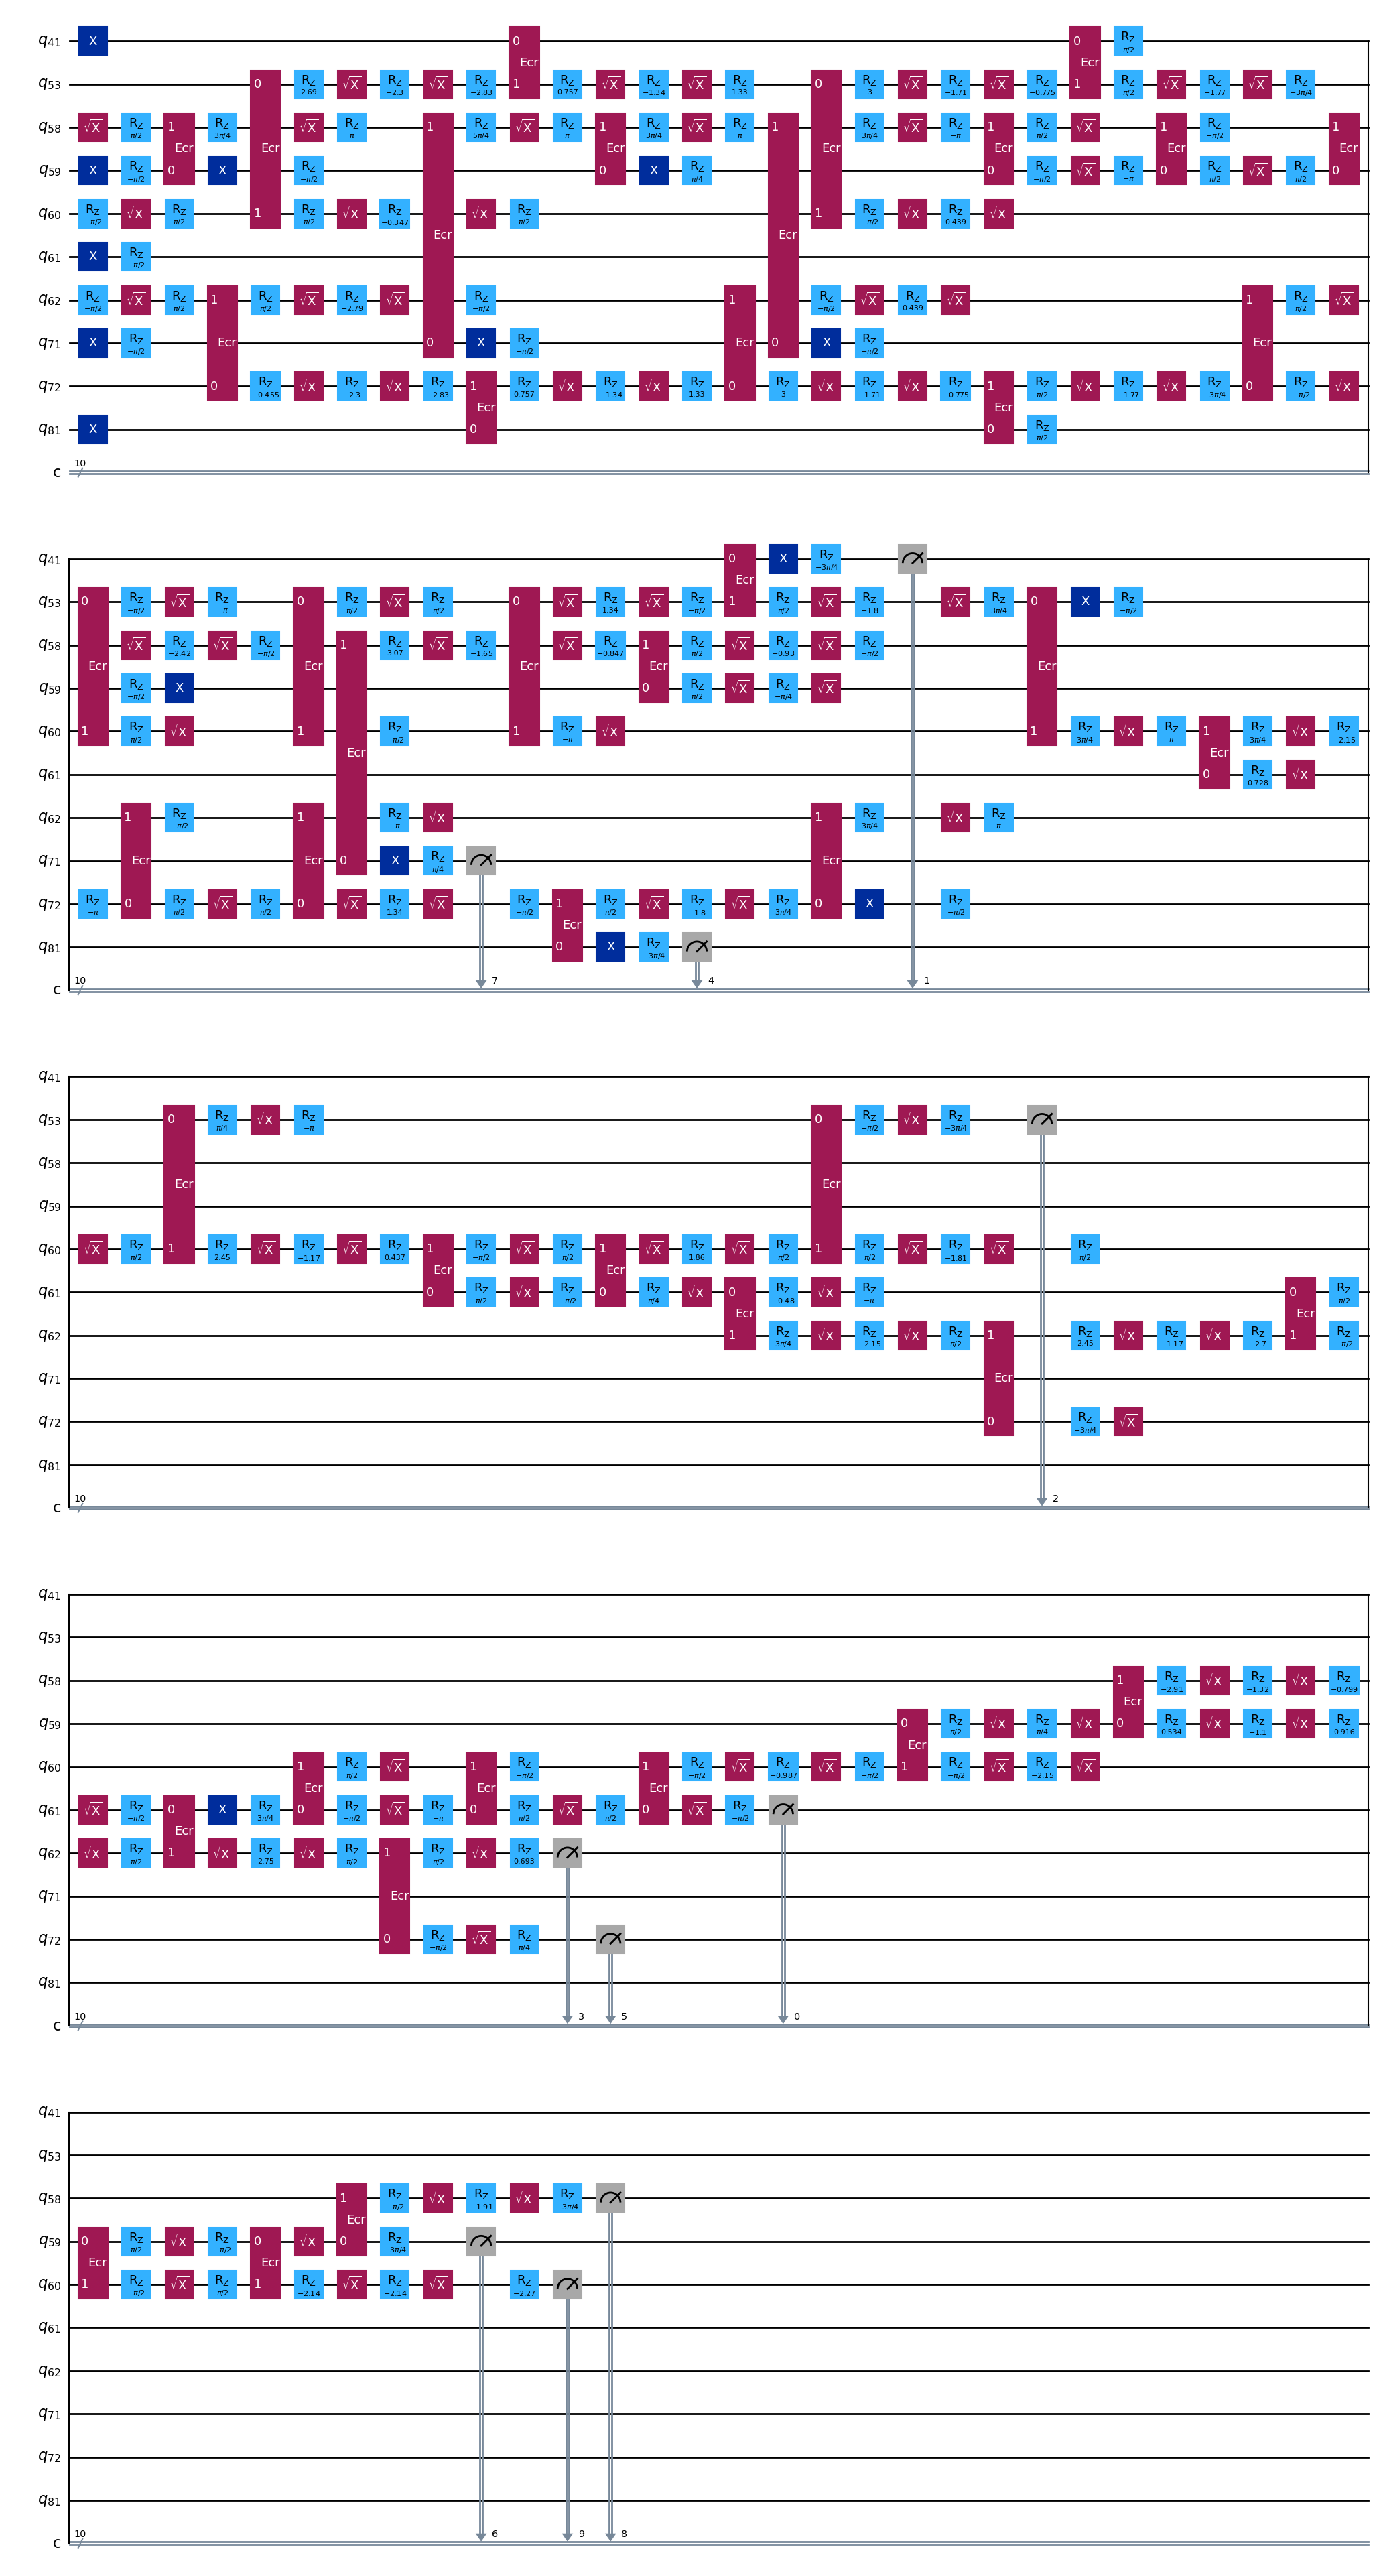

In [183]:
# The path is coming from the config file, but you can also modify it here
conf.base_folder = "./circuits/testing/"
qasm_files = q.get_qasm_files_from_path()
print(qasm_files)

qc = q.get_circuit_properties(qasm_source=qasm_files[0])
qc.circuit.draw(idle_wires=False)

#qc = QuantumCircuit(2)
#qc.x(0)
#qc.barrier(0,1)
#qc.cx(0,1)
#qc.measure_all()

#pm = generate_preset_pass_manager(optimization_level=1, backend=noisy_simulator)
#isa_circuit = pm.run(qc.circuit)

#print(dumps(isa_circuit))
updated_qasm, initial_mapping = q.compile(qasm=qc.qasm_original, compilation_name="qiskit_3")
compiled_qc = QuantumCircuit.from_qasm_str(updated_qasm)
compiled_qc.draw("mpl", idle_wires=False, fold=30)

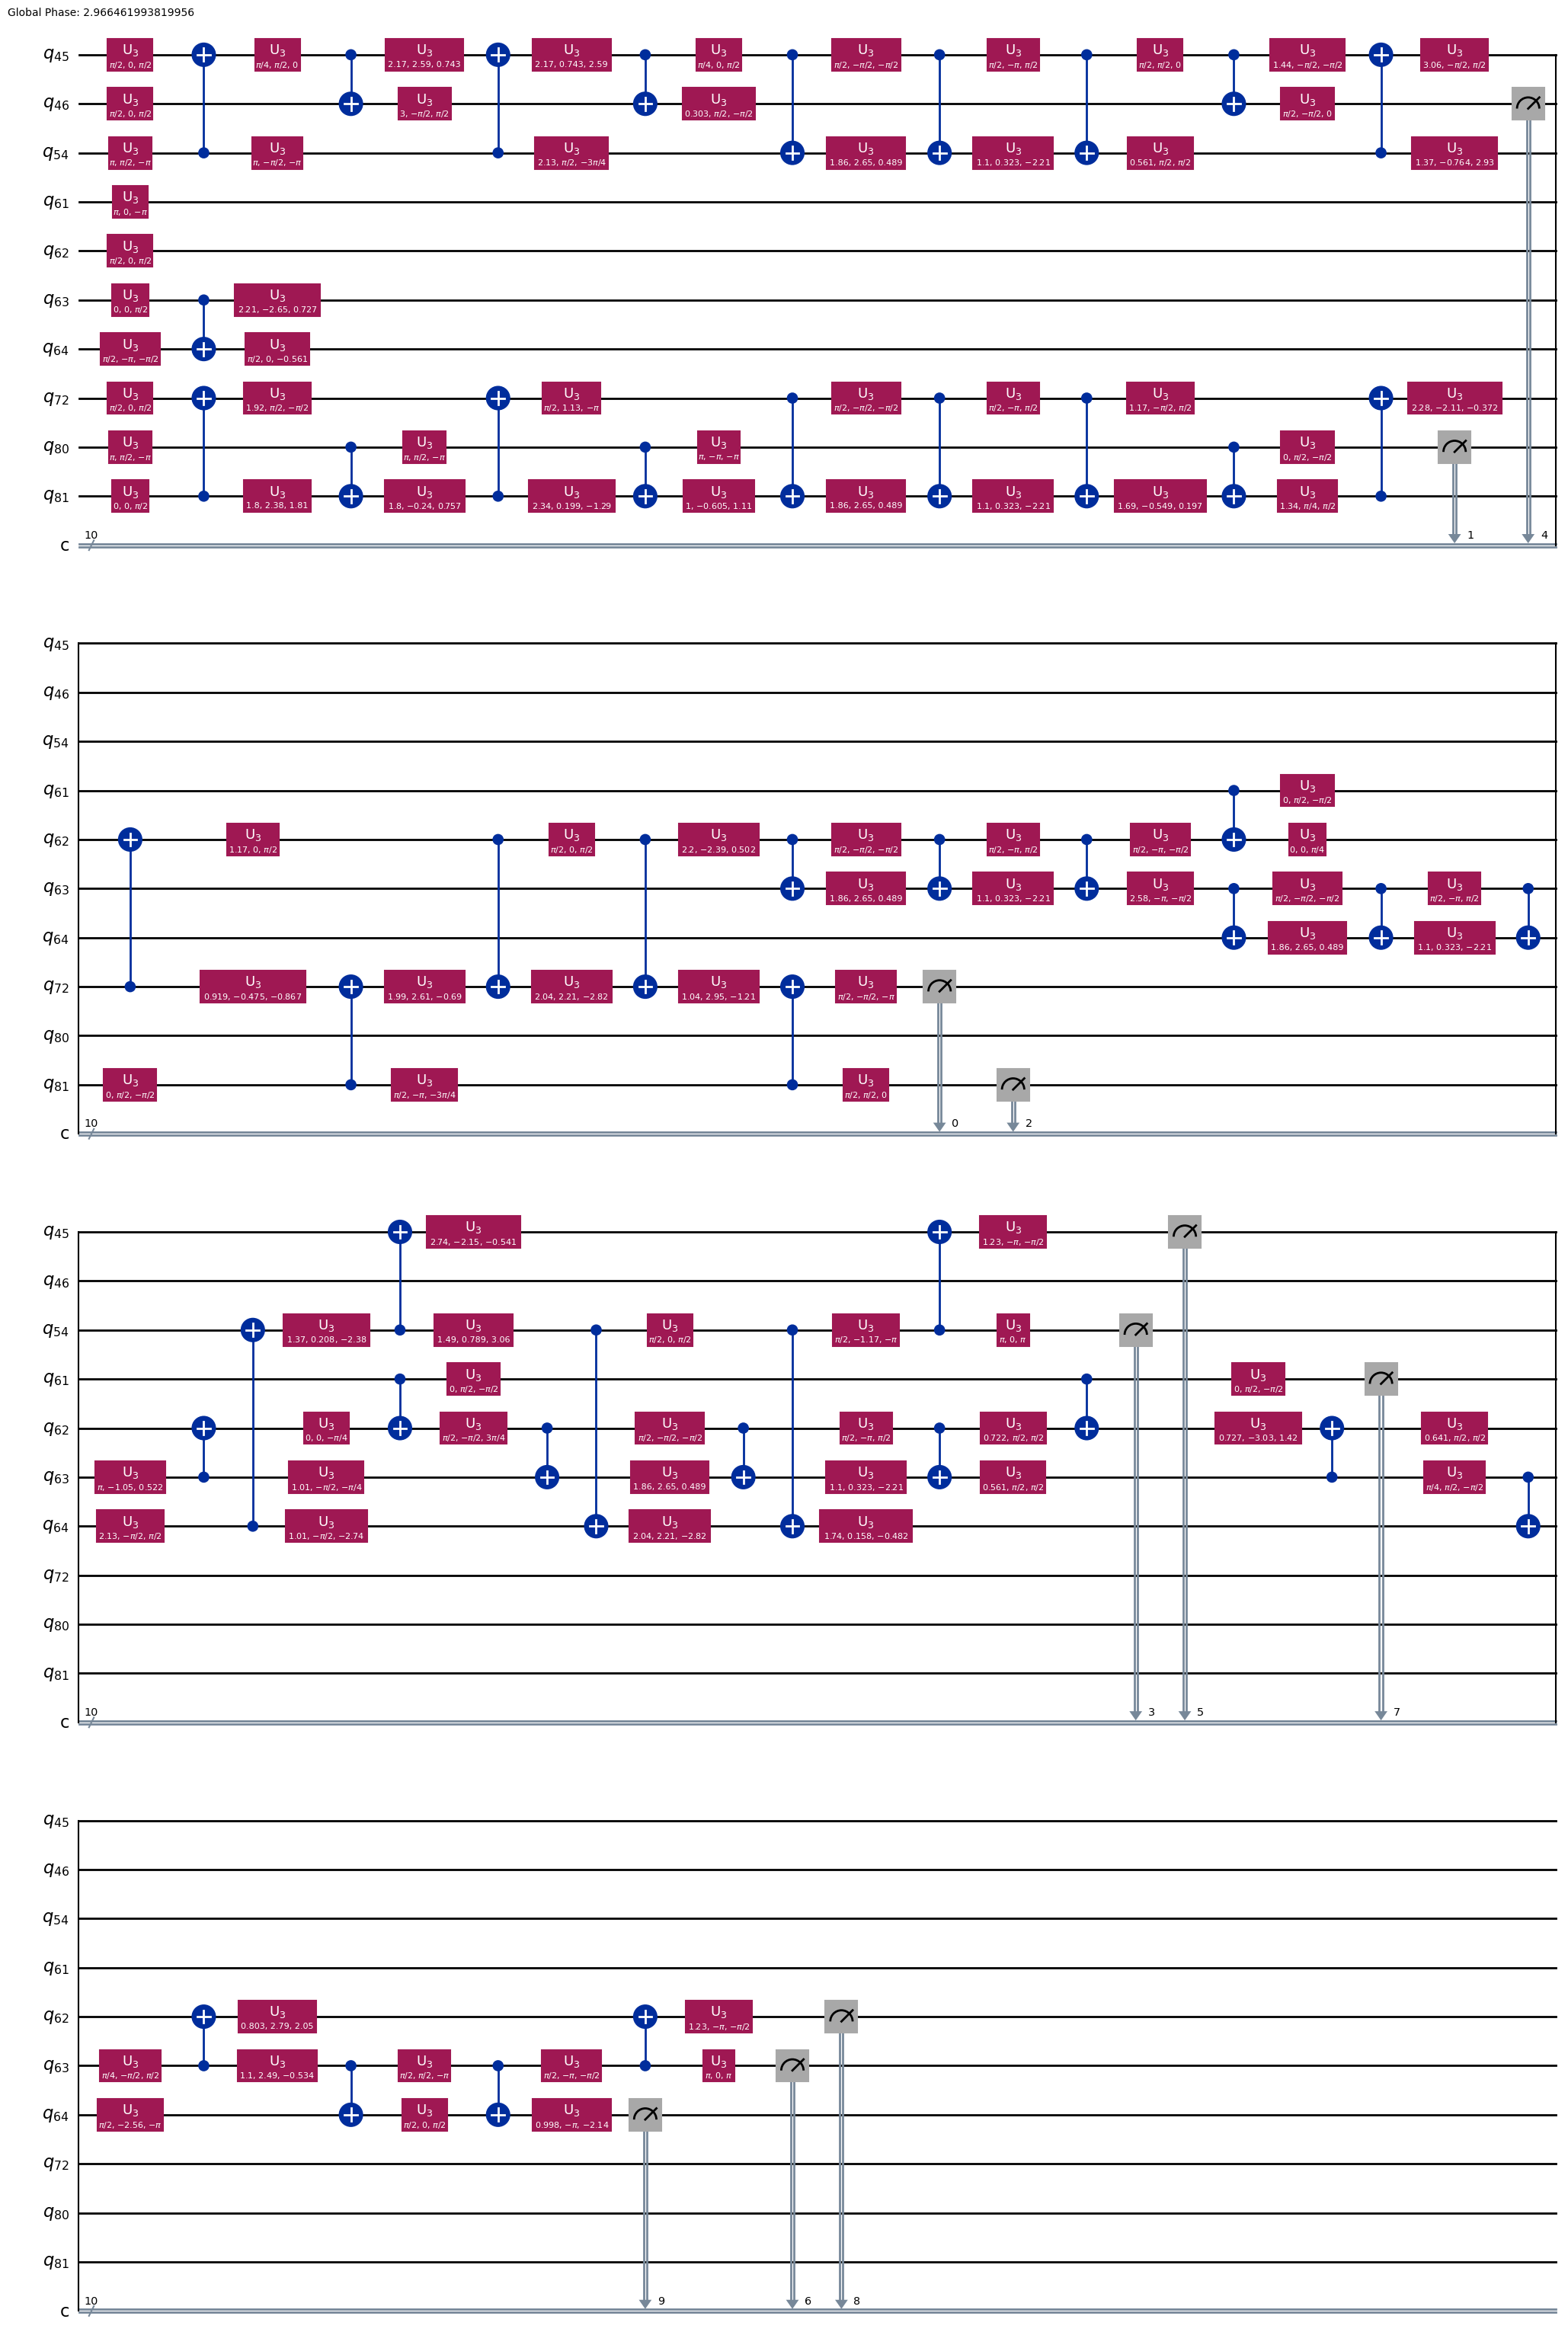

In [182]:
n_qubits = 10
depth_circuit = 100
shots = 10 ** 6

#circuit = generate_rb_circuits(n_qubits, depth_circuit,return_type="qiskit")[0]
#circuit.measure_all()

#qc = q.get_circuit_properties(qasm_source=dumps(circuit))

#updated_qasm, initial_mapping = q.compile(qasm=qc.qasm_original, compilation_name="qiskit_0")
#compiled_qc = QuantumCircuit.from_qasm_str(updated_qasm)
#compiled_qc.draw("mpl", idle_wires=False, fold=30)

#circuit = compiled_qc
circuit = transpile(compiled_qc, basis_gates=["u3","cx"], optimization_level=3)
circuit.draw("mpl", idle_wires=False, fold=30)

In [176]:
def execute_circuit(circuit):
    """Execute the input circuit and return the expectation value of |00..0><00..0|"""
    noisy_backend = noisy_simulator
    noisy_result = noisy_backend.run(circuit, shots=shots).result()
    noisy_counts = noisy_result.get_counts(circuit)
    #print(noisy_counts)
    noisy_expectation_value = noisy_counts["1111111011"] / shots
    return noisy_expectation_value

In [177]:
mitigated = execute_with_zne(circuit, execute_circuit, factory=LinearFactory([1, 3, 5]))
unmitigated = execute_circuit(circuit)
ideal = 1 #property of RB circuits

print("ideal = \t \t",ideal)
print("unmitigated = \t \t", "{:.5f}".format(unmitigated))
print("mitigated = \t \t", "{:.5f}".format(mitigated))

ideal = 	 	 1
unmitigated = 	 	 0.75429
mitigated = 	 	 0.75448


In [178]:
def execute_calibration(qiskit_circuit):
    """Execute the input circuits and return the measurement results."""
    noisy_backend = noisy_simulator
    noisy_result = noisy_backend.run(qiskit_circuit, shots=shots).result()
    noisy_counts = noisy_result.get_counts(qiskit_circuit)
    noisy_counts = { k.replace(" ",""):v for k, v in noisy_counts.items()}
    measurements = MeasurementResult.from_counts(noisy_counts)
    return measurements

In [179]:
RBSettings = Settings(
    benchmarks=[
        {
            "circuit_type": "rb",
            "num_qubits": 2,
            "circuit_depth": int(depth_circuit / 2),
        },
    ],
    strategies=[
        {
            "technique": "zne",
            "scale_noise": fold_global,
            "factory": RichardsonFactory([1.0, 2.0, 3.0]),
        },
        {
            "technique": "zne",
            "scale_noise": fold_global,
            "factory": RichardsonFactory([1.0, 3.0, 5.0]),
        },
        {
            "technique": "zne",
            "scale_noise": fold_global,
            "factory": LinearFactory([1.0, 2.0, 3.0]),
        },
        {
            "technique": "zne",
            "scale_noise": fold_global,
            "factory": LinearFactory([1.0, 3.0, 5.0]),
        },

        {
            "technique": "zne",
            "scale_noise": fold_gates_at_random,
            "factory": RichardsonFactory([1.0, 2.0, 3.0]),
        },
        {
            "technique": "zne",
            "scale_noise": fold_gates_at_random,
            "factory": RichardsonFactory([1.0, 3.0, 5.0]),
        },
        {
            "technique": "zne",
            "scale_noise": fold_gates_at_random,
            "factory": LinearFactory([1.0, 2.0, 3.0]),
        },
        {
            "technique": "zne",
            "scale_noise": fold_gates_at_random,
            "factory": LinearFactory([1.0, 3.0, 5.0]),
        },

        {
            "technique": "zne",
            "scale_noise": fold_all,
            "factory": RichardsonFactory([1.0, 2.0, 3.0]),
        },
        {
            "technique": "zne",
            "scale_noise": fold_all,
            "factory": RichardsonFactory([1.0, 3.0, 5.0]),
        },
        {
            "technique": "zne",
            "scale_noise": fold_all,
            "factory": LinearFactory([1.0, 2.0, 3.0]),
        },
        {
            "technique": "zne",
            "scale_noise": fold_all,
            "factory": LinearFactory([1.0, 3.0, 5.0]),
        },

    ],
)

In [180]:
cal = Calibrator(execute_calibration, frontend="qiskit", settings=RBSettings)
cal.run(log="flat")

┌──────────────────────────┬────────────────────────────────────┬────────────────────────────┐
│ benchmark                │ strategy                           │ performance                │
├──────────────────────────┼────────────────────────────────────┼────────────────────────────┤
│ Type: rb                 │ Technique: ZNE                     │ ✔                          │
│ Num qubits: 2            │ Factory: Linear                    │ Noisy error: 0.0434        │
│ Circuit depth: 308       │ Scale factors: 1.0, 2.0, 3.0       │ Mitigated error: 0.0072    │
│ Two qubit gate count: 69 │ Scale method: fold_all             │ Improvement factor: 6.0385 │
├──────────────────────────┼────────────────────────────────────┼────────────────────────────┤
│ Type: rb                 │ Technique: ZNE                     │ ✔                          │
│ Num qubits: 2            │ Factory: Richardson                │ Noisy error: 0.0434        │
│ Circuit depth: 308       │ Scale factors: 1.0, 2

In [181]:
calibrated_mitigated=execute_with_mitigation(circuit, execute_circuit, calibrator=cal)
mitigated=execute_with_zne(circuit, execute_circuit, factory=LinearFactory([1, 3, 5]))
unmitigated=execute_circuit(circuit)

print("ideal = \t \t",ideal)
print("unmitigated = \t \t", "{:.5f}".format(unmitigated))
print("mitigated = \t \t", "{:.5f}".format(mitigated))
print("calibrated_mitigated = \t", "{:.5f}".format(calibrated_mitigated))

ideal = 	 	 1
unmitigated = 	 	 0.75397
mitigated = 	 	 0.75416
calibrated_mitigated = 	 0.75342


#### Tutorial ZNE Mitiq with Qiskit

In [115]:
import qiskit
from qiskit_aer import QasmSimulator
from qiskit_ibm_runtime import QiskitRuntimeService

from mitiq import zne
from mitiq.interface.mitiq_qiskit.qiskit_utils import initialized_depolarizing_noise
USE_REAL_HARDWARE = False

In [125]:
qreg, creg = qiskit.QuantumRegister(1), qiskit.ClassicalRegister(1)
circuit = qiskit.QuantumCircuit(qreg, creg)
for _ in range(50):
    circuit.x(qreg)
circuit.measure(qreg, creg)
print(circuit)

      ┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐»
q547: ┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├»
      └───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘»
c2: 1/══════════════════════════════════════════════════════════════════════»
                                                                            »
«      ┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐»
«q547: ┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├»
«      └───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘»
«c2: 1/══════════════════════════════════════════════════════════════════════»
«                                                                            »
«      ┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐»
«q547: ┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├»
«      └───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘

In [126]:
if QiskitRuntimeService.saved_accounts() and USE_REAL_HARDWARE:
    service = QiskitRuntimeService()
    backend = service.least_busy(operational=True, simulator=False)
    noise_model = False
else:
    # Simulate the circuit with noise
    noise_model = initialized_depolarizing_noise(noise_level=0.02)
    # Default to a simulator
    backend = noisy_simulator


def ibmq_executor(circuit: qiskit.QuantumCircuit, shots: int = 8192) -> float:
    """Returns the expectation value to be mitigated.

    Args:
        circuit: Circuit to run.
        shots: Number of times to execute the circuit to compute the expectation value.
    """
    # Transpile the circuit so it can be properly run
    exec_circuit = qiskit.transpile(
        circuit,
        backend=backend,
        basis_gates=noise_model.basis_gates if noise_model else None,
        optimization_level=0, # Important to preserve folded gates.
    )
    
    # Run the circuit
    job = backend.run(circuit, shots=shots)

    # Convert from raw measurement counts to the expectation value
    counts = job.result().get_counts()
    if counts.get("0") is None:
        expectation_value = 0.
    else:
        expectation_value = counts.get("0") / shots
    return expectation_value

In [127]:
unmitigated = ibmq_executor(circuit)
mitigated = zne.execute_with_zne(circuit, ibmq_executor)
print(f"Unmitigated result {unmitigated:.3f}")
print(f"Mitigated result {mitigated:.3f}")

Unmitigated result 0.984
Mitigated result 0.999


In [128]:
linear_factory = zne.inference.LinearFactory(scale_factors=[1.0, 1.5, 2.0, 2.5, 3.0])
mitigated = zne.execute_with_zne(circuit, ibmq_executor, factory=linear_factory)
print(f"Mitigated result {mitigated:.3f}")

Mitigated result 0.996


In [141]:
mitigated = zne.execute_with_zne(circuit, ibmq_executor, scale_noise=zne.scaling.fold_global)
print(f"Mitigated result {mitigated:.3f}")

Mitigated result 0.990


In [142]:
scale_factors = [1., 1.5, 2., 2.5, 3.]
folded_circuits = [
        zne.scaling.fold_gates_at_random(circuit, scale)
        for scale in scale_factors
]

# Check that the circuit depth is (approximately) scaled as expected
for j, c in enumerate(folded_circuits):
    print(f"Number of gates of folded circuit {j} scaled by: {len(c) / len(circuit):.3f}")

Number of gates of folded circuit 0 scaled by: 1.000
Number of gates of folded circuit 1 scaled by: 1.510
Number of gates of folded circuit 2 scaled by: 1.980
Number of gates of folded circuit 3 scaled by: 2.451
Number of gates of folded circuit 4 scaled by: 2.961


In [143]:
shots = 8192

# Transpile the circuit so it can be properly run
exec_circuit = qiskit.transpile(
    folded_circuits,
    backend=noisy_simulator,
    basis_gates=noise_model.basis_gates if noise_model else None,
    optimization_level=0, # Important to preserve folded gates.
)

# Run the circuit
job = backend.run(exec_circuit, shots=shots)

In [144]:
all_counts = [job.result().get_counts(i) for i in range(len(folded_circuits))]
expectation_values = [counts.get("0") / shots for counts in all_counts]
print(f"Expectation values:\n{expectation_values}")

Expectation values:
[0.9969482421875, 0.9976806640625, 0.9970703125, 0.9970703125, 0.9974365234375]


In [145]:
print("Unmitigated expectation value:", round(expectation_values[0], 6))
zero_noise_value = zne.ExpFactory.extrapolate(scale_factors, expectation_values, asymptote=0.5)
print(f"Extrapolated zero-noise value:", round(zero_noise_value, 6))


Unmitigated expectation value: 0.996948
Extrapolated zero-noise value: 0.997095


## DDD

# Estimator (Pending)

In [ ]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit_aer import AerSimulator
import matplotlib.pyplot as plt

qc = QuantumCircuit(3)
qc.h(0)
qc.cx(0, 1)
qc.cx(1, 2)
qc.draw("mpl")

ZZ = SparsePauliOp('ZZZ')
ZI = SparsePauliOp('ZII')
IX = SparsePauliOp('IXI')
IZ = SparsePauliOp('IZI')
XI = SparsePauliOp('XII')
XX = SparsePauliOp('XXX')
observables = [IZ, IX, ZI, XI, ZZ, XX]


In [ ]:
updated_qasm, initial_mapping = q.compile(qasm=dumps(qc), compilation_name="qiskit_3")
compiled_qc = QuantumCircuit.from_qasm_str(updated_qasm)
compiled_qc.draw(idle_wires=False)

In [ ]:
transpiled_obs = []
for obs in observables:
    transpiled_obs.append(obs.apply_layout(layout=compiled_qc.layout))
transpiled_obs

In [ ]:
print(dumps(compiled_qc))

In [ ]:
noise_model, noisy_simulator, coupling_map = qiskit_wrapper.get_noisy_simulator(q.backend, 1)

n_qubits = 127
observable = SparsePauliOp("Z" * n_qubits)

pm = generate_preset_pass_manager(optimization_level=3, backend=noisy_simulator)
isa_circuit = pm.run(compiled_qc)
isa_observable = observable.apply_layout(isa_circuit.layout)
 
job = estimator.run([(isa_circuit, isa_observable)])
result = job.result()


In [ ]:
# Collect the data
data = ['IZI', 'IXI', 'ZII', 'XII', 'ZZZ', 'XXX']
values = job.result()[0].data.evs

# Set up our graph
container = plt.plot(data, values, '-o')

# Label each axis
plt.xlabel('Observables')
plt.ylabel('Values')

# Draw the final graph
plt.show()

In [ ]:
import numpy as np
from qiskit.circuit.library import IQP
from qiskit.quantum_info import SparsePauliOp, random_hermitian
from qiskit_ibm_runtime import EstimatorV2 as Estimator, QiskitRuntimeService
 
estimator = Estimator(noisy_simulator)
 
n_qubits = 3
 
circuit = qc
observable = SparsePauliOp("Z" * n_qubits)
 
pm = generate_preset_pass_manager(optimization_level=1, backend=noisy_simulator)
isa_circuit = pm.run(circuit)
isa_observable = observable.apply_layout(isa_circuit.layout)
 
job = estimator.run([(isa_circuit, isa_observable)])
result = job.result()
 
print(f" > Expectation value: {result[0].data.evs}")
print(f" > Metadata: {result[0].metadata}")

In [ ]:
import numpy as np
from typing import List, Callable
from scipy.optimize import minimize
from scipy.optimize._optimize import OptimizeResult
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector, Operator, SparsePauliOp
from qiskit.primitives import StatevectorSampler, PrimitiveJob
from qiskit.circuit.library import TwoLocal
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.visualization import plot_histogram
from qiskit_ibm_runtime.fake_provider import FakeSherbrooke
from qiskit_ibm_runtime import Session, EstimatorV2 as Estimator
from qiskit_aer import AerSimulator
from qiskit.circuit.library import EfficientSU2

pauli_op = SparsePauliOp(['ZII', 'IZI', 'IIZ'])
print(pauli_op.to_matrix())

In [ ]:
num_qubits = 3 #Add your code here
rotation_blocks = ["ry","rz"] #Add your code here
entanglement_blocks = "cz" #Add your code here
entanglement = "full" #Add your code here

ansatz = TwoLocal(num_qubits, ['ry','rz'], 'cz', 'full', reps=1, insert_barriers=True) #Add your code here

### Don't change any code past this line ###
ansatz.decompose().draw('mpl')

In [ ]:
num_params = ansatz.num_parameters
backend_answer = noisy_simulator #Add your code
optimization_level_answer = 3 #Add your code
pm = generate_preset_pass_manager(backend=backend_answer,optimization_level=optimization_level_answer)
isa_circuit = pm.run(ansatz) # Add your code
hamiltonian_isa = pauli_op.apply_layout(layout=isa_circuit.layout)

In [ ]:
isa_circuit.draw('mpl', idle_wires=False, fold=50)

In [ ]:
initial_mapping = qiskit_wrapper.get_initial_layout_from_circuit(isa_circuit)
initial_mapping

### Mthree

In [ ]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister

x0 = 2 * np.pi * np.random.random(num_params)
bound_circs = isa_circuit.assign_parameters(x0)
creg = ClassicalRegister(3, 'c')
bound_circs.add_register(creg)
bound_circs.measure(40, 0)
bound_circs.measure(39, 1)
bound_circs.measure(38, 2)
result = noisy_simulator.run(bound_circs, shots=10000).result()
counts = result.get_counts()

mit = mthree.M3Mitigation(noisy_simulator)
mit.cals_from_system(initial_mapping)

quasis = mit.apply_correction(counts, initial_mapping)

coeffs = []
meas_strings = []

for i in pauli_op.to_list():
    meas_string, coeff = i
    coeffs.append(coeff)
    meas_strings.append(meas_string)

print(meas_strings, coeffs)
print(np.sum(coeffs * quasis.expval(meas_strings)))


## Classical Optimizer

In [ ]:
def cost_func(params, ansatz, hamiltonian, estimator, callback_dict):
    """Return estimate of energy from estimator

    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (EstimatorV2): Estimator primitive instance

    Returns:
        float: Energy estimate
    """
    pub = (ansatz, [hamiltonian], [params]) #Add your code
    result = estimator.run(pubs=[pub]).result() #Add your code
    energy = result[0].data.evs[0] #Add your code

    callback_dict["iters"] += 1 #Add your code
    callback_dict["prev_vector"] = params #Add your code
    callback_dict["cost_history"].append(energy) #Add your code


### Don't change any code past this line ###
    print(energy)
    return energy, result

In [ ]:
ansatz = EfficientSU2(3)
params = np.ones((1,ansatz.num_parameters))
aer_sim = noisy_simulator
pm = generate_preset_pass_manager(backend=aer_sim, optimization_level=3)
isa_circuits = pm.run(ansatz)
choc_op = SparsePauliOp(['ZII', 'IZI', 'IIZ'])
hamiltonian_isa = choc_op.apply_layout(layout=isa_circuits.layout)
estimator = Estimator(mode=aer_sim)

callback_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": []
}
cost, result = cost_func(
    params,
    isa_circuits,
    hamiltonian_isa,
    estimator,
    callback_dict
)

In [ ]:
callback_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}

In [ ]:
x0 = 2 * np.pi * np.random.random(num_params)
x0

In [ ]:
# backend = FakeSherbrooke()
backend = noisy_simulator

# ### Don't change any code past this line ###

# Here we have updated the cost function to return only the energy to be compatible with recent scipy versions (>=1.10)
def cost_func_2(*args, **kwargs):
    energy, result = cost_func(*args, **kwargs)
    return energy

with Session(backend=backend) as session:
    estimator = Estimator(mode=session)

    res = minimize(
        cost_func_2,
        x0,
        args=(isa_circuit, hamiltonian_isa, estimator, callback_dict),
        method="cobyla",
        options={'maxiter': 10})

In [ ]:
fig, ax = plt.subplots()
plt.plot(range(callback_dict["iters"]), callback_dict["cost_history"])
plt.xlabel("Energy")
plt.ylabel("Cost")
plt.draw()

## Error Mitigation

 More detais about how to configure error mitigation with for Qiskit runtime can be found in [this tutorial](https://learning.quantum.ibm.com/tutorial/combine-error-mitigation-options-with-the-estimator-primitive) as well as in [the documentation](https://docs.quantum.ibm.com/run/configure-error-mitigation).


When using the Estimator primitive, we can use the ```EstimatorOptions()``` object to set the options for error mitigation and error suppression techniques. This table shows the most used ones:

| Options              | Sub-options              | Sub-sub-options         | Choices                                                                                   | Default                   |
|----------------------|--------------------------|-------------------------|-------------------------------------------------------------------------------------------|---------------------------|
| default_shots        |                          |                         |                                                                                           | `4096`                      |
| optimization_level   |                          |                         | `0`/`1`                                                                                       | `1`                         |
| resilience_level     |                          |                         | `0`/`1`/`2`                                                                                     | `1`                         |
| dynamical_decoupling | enable                   |                         |`True`/`False`                                                                                           |`False`                           |
|                      | sequence_type            |                         | `'XX'`/`'XpXm'`/`'XY4'`                                                                         | `'XX'`                      |
|                      | extra_slack_distribution |                         | `'middle'`/`'edges'`                                                                          | `'middle'`                  |
|                      | scheduling_method        |                         | `'asap'`/`'alap'`                                                                            | `'alap'`                    |
| resilience           | measure_mitigation       |                         | `True`/`False`                                                                                | `True`                      |
|                      | measure_noise_learning   | num_randomizations      |                                                                                           | `32`                      |
|                      |                          | shots_per_randomization |                                                                                           | `'auto'`                    |
|                      | zne_mitigation           |                         | `True`/`False`                                                                                | `False`                     |
|                      | zne                      | noise_factors           |                                                                                           | `(1, 3, 5)`                 |
|                      |                          | extrapolator            | `'exponential'`/<br>`'linear'`/<br>`'double_exponential'`/<br>`'polynomial_degree_(1 <= k <= 7)'` | (`'exponential'`, `'linear'`) |
| twirling             | enable_gates             |                         | `True`/`False`                                                                                      | `False`                     |
|                      | enable_measure           |                         | `True`/`False`                                                                                      | `True`                      |
|                      | num_randomizations       |                         |                                                                                           | `'auto'`                    |
|                      | shots_per_randomization  |                         |                                                                                           | `'auto'`                    |
|                      | strategy                 |                         | `'active'`/<br>`'active-circuit'`/<br>`'active-accum'`/<br>`'all'`                                | `'active-accum'`            |

### Dynamical Decoupling (DD)

As we have seen in the section above, qubits can lose their information over time due to decoherence and can further be influenced by operations applied to other qubits via cross talk. These effects are especially recognizable if the qubits are already initialized in a quantum state but are not being used for an extended period during the calculation.

To eliminate these effects, we can use dynamic decoupling, which adds pulse sequences (known as dynamical decoupling sequences) to flip idle qubits around the Bloch sphere, canceling the effect of noise channels and thereby suppressing the decoherence effect.

In these 2 graphics below we can see X-gates being applied on qubits which are idle. Since we apply an even number of X-gates, the result is the identity and thus the effect of the X-gates cancel each other.


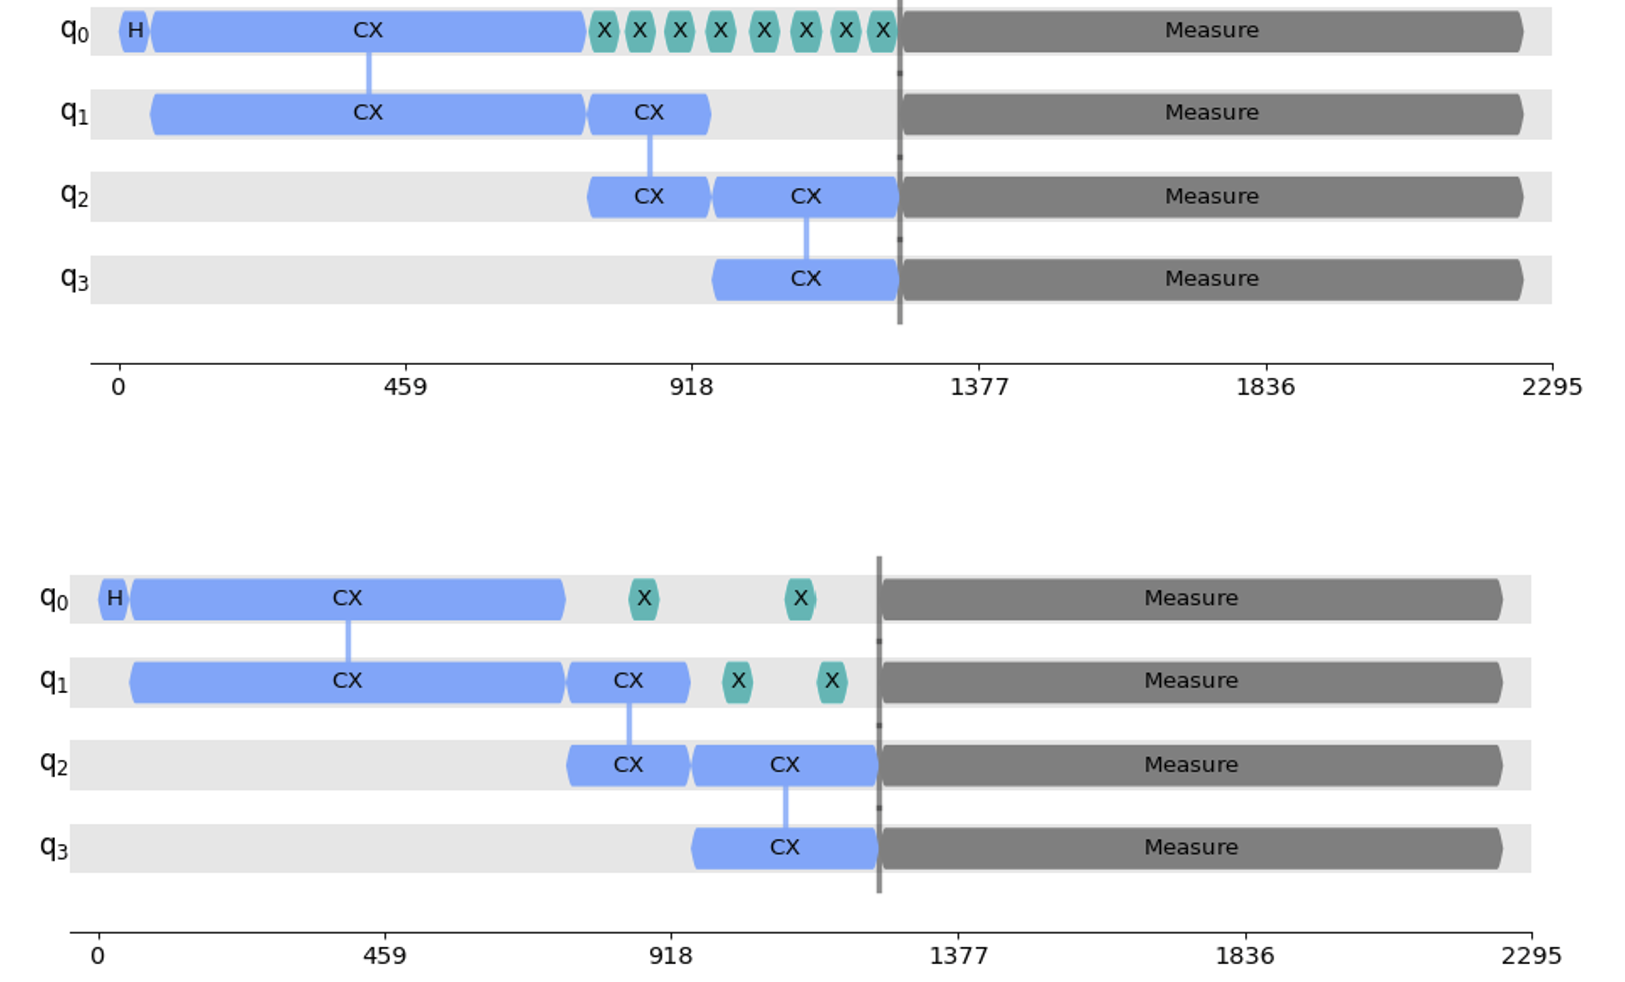


You can find more information about the dynamical decoupling [here](https://docs.quantum.ibm.com/transpile/dynamical-decoupling-pass-manager).


In [ ]:

circ = QuantumCircuit(5)
circ.h(0)
circ.ecr(0, 1)
circ.ecr(1, 2)
circ.ecr(2, 3)
circ.ecr(3, 4)
circ.measure_all()

#transpiled_qasm, initial_mapping = q.compile(qasm=dumps(circ), compilation_name="qiskit_3")
#transpiled_circ = QuantumCircuit.from_qasm_str(transpiled_qasm)
target = noisy_simulator.target
basis_gates = list(target.operation_names)

pm = generate_preset_pass_manager(3, target=target, seed_transpiler=12345)
transpiled_circ = pm.run(circ)

transpiled_circ.draw("mpl", idle_wires=False, fold=60)

In [ ]:
circuit_dd = apply_dd(noisy_simulator, transpiled_circ)
timeline_drawer(circuit_dd, show_idle=False)


In [ ]:
circuit_dd.draw("mpl", idle_wires=False, fold=60)

In [ ]:
job = noisy_simulator.run(circuit_dd, shots=10000)
result = job.result()  
output = result.get_counts()
output_normalize = normalize_counts(output, shots=shots)
output

In [ ]:
circ_dd.draw("mpl")

In [ ]:
from qiskit_ibm_runtime import (
    QiskitRuntimeService,
    EstimatorV2 as Estimator,
    SamplerV2 as Sampler,
    EstimatorOptions, SamplerOptions
)

In [ ]:
## DD
options = SamplerOptions(
    default_shots=5000,
    dynamical_decoupling={
        'enable':True, 
        'sequence_type':'XpXm', 
        'extra_slack_distribution':'middle',
        'scheduling_method':'alap'},
    execution={
        'init_qubits':True,
         #'rep_delay':
    },
    twirling={
        'enable_gates': False, 
        'enable_measure': True,
        'num_randomizations':'auto',
        'shots_per_randomization':'auto',
        'strategy':'all'
    }
) 

In [ ]:
sampler = Sampler(mode=backend_service, options=options)

In [ ]:
qasm = QiskitCircuit(dumps(circ))
compiled_circuit = qasm.transpile_to_target_backend(q.backend)

In [ ]:
sampler.run([compiled_circuit])

### Zero Noise Extrapolation (ZNE)

In [ ]:
durations = InstructionDurations.from_backend(backend_service)


In [ ]:
durations.get('id', (3,))

In [ ]:
durations.duration_by_name_qubits[('id', (0, ))][1]

In [ ]:
from qiskit import QuantumCircuit
from qiskit import QuantumCircuit, transpile
from qiskit.circuit.library import ECRGate
from qiskit.circuit.library import RZXGate
from mitiq import zne
from mitiq.interface import convert_to_mitiq

theta = np.pi / 2
rzx_gate = RZXGate(theta)

def rzx_gate(circuit, control, target):
    #h q1; cx q0,q1; rz(pi/4) q1; cx q0,q1; h q1;
    circuit.h(target)
    circuit.cx(control,target)
    circuit.rz(np.pi/4, target)
    circuit.cx(control,target)
    circuit.h(target)

def rzxt_gate(circuit, control, target):
    #h q1; cx q0,q1; rz(-pi/4) q1; cx q0,q1; h q1;
    circuit.h(target)
    circuit.cx(control,target)
    circuit.rz(-np.pi/4, target)
    circuit.cx(control,target)
    circuit.h(target)

def ecr_gate(circuit, control, target):
    # rzx(pi/4) q0,q1; x q0; rzxt(-pi/4) q0,q1; }
    rzx_gate(circuit, control, target)
    circuit.x(control)
    rzxt_gate(circuit, control, target)

def cx_to_ecr(circuit, control, target):
#sx q[0]; rz(-pi / 2) q[1]; rz(-pi / 2) q[0]; sx q[1]; rz(-pi) q[1]; ecr q[1], q[0];
#rz(-pi / 2) q[0]; rz(pi / 2) q[1]; sx q[0]; sx q[1]; rz(pi / 2) q[0]; rz(pi / 2) q[1];
    circuit.sx(control)
    circuit.rz(-np.pi/2, target)
    circuit.rz(-np.pi/2, control)
    circuit.sx(target)
    circuit.rz(-np.pi, target)
    ecr_gate(circuit, target, control)
    circuit.rz(-np.pi/2, control)
    circuit.rz(np.pi/2, target)
    circuit.sx(control)
    circuit.sx(target)
    circuit.rz(np.pi/2, control)
    circuit.rz(np.pi/2, target)
    
# Create a quantum circuit with ECR gates
n_qubits = 2
circuit = QuantumCircuit(2)
circuit.x(0)
circuit.barrier(0,1)
cx_to_ecr(circuit, 0, 1)
#circuit.cx(0,1)
#circuit.ecr(0,1)
circuit.measure_all()
circuit = transpile(circuit, basis_gates=["u3","cx"])

print(dumps(circuit))
circuit.draw("mpl", fold=60)

convert_to_mitiq(circuit)
